In [ ]:
%matplotlib widget
import torch
import os
import copy
import subprocess
import shlex

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.schema import getSimulationScheme
from sphMath.enums import *

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 128
L = 2
dim = 2
kernel = 'Wendland4'
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3

integrationScheme = 'symplecticEuler'
dx = L / nx
band = 5

domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
# domain.min = torch.tensor([-L/2, -2*L], device = device, dtype = dtype)
# domain.max = torch.tensor([L/2, 2*L], device = device, dtype = dtype)
# print(domain.min)
# domain.min = torch.tensor([-2*L/2,-L/2], device = device, dtype = dtype)
# domain.max = torch.tensor([5*L/2,L/2], device = device, dtype = dtype)
# interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'verletScale': 1.4,
    'shifting': {'scheme': 'delta', 'freeSurface': False},
    'surfaceDetection': {'active': False},
    'pressure':{'term': 'Antuono'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 9.81, 'mode': 'directional', 'direction': torch.tensor([0, -1], device = device, dtype = dtype)},
    'particle': {'nx': nx, 'dx': dx, 'targetNeighbors': targetNeighbors, 'band': band, 'support': volumeToSupport((L/nx)**dim, targetNeighbors, dim)},
}

In [40]:
from sphMath.sampling import generateNoiseInterpolator
from sphMath.util import getPeriodicPositions
from sphMath.sampling import generateRamp, rampDivergenceFree
import numpy as np
nxGrid = nx * 2
octaves = 5
lacunarity = 2
persistence = 0.5
baseFrequency = 2
tileable = True
kind = 'perlin'
seed = 4039567

domain_cpu = buildDomainDescription(l = L, dim = dim, periodic = True, device = torch.device('cpu'), dtype = dtype)
domain_cpu.min = domain.min.cpu()
domain_cpu.max = domain.max.cpu()
noiseGen = generateNoiseInterpolator(nxGrid, nxGrid, domain_cpu, dim = domain.dim, octaves = octaves, lacunarity = lacunarity, persistence = persistence, baseFrequency = baseFrequency, tileable = tileable, kind = kind, seed = seed)

k = 4
xi = 1
noiseLevel = 0.01

# Kolmogorov turbulence
def forcing(x):
    pos = getPeriodicPositions(x, domain)
    regions = config['regions']
    boundary_sdfs = [region['sdf'] for region in regions if region['type'] == 'boundary']
    combined_sdf = lambda x: boundary_sdfs[0](x)[0]
    for sdf in boundary_sdfs[1:]:
        combined_sdf = operatorDict['union'](combined_sdf, lambda x: sdf(x)[0])


    buffer = config.get('boundary', {}).get('potentialBuffer', 4)
    ramp = rampDivergenceFree(pos, torch.ones_like(pos[:,0]), combined_sdf, 
                              offset = config['particle']['dx']/2, 
                              d0 = buffer * config['particle']['support'])

    noiseOffset = torch.rand(pos.shape[1], device = device, dtype = dtype) * L - L/2
    noisePos = getPeriodicPositions(x + noiseOffset, domain)

    # ramp = generateRamp()
    u_x = xi * torch.sin(k * np.pi * pos[:,1]) * ramp
    u_y = noiseGen(pos.detach().cpu()).to(dtype = x.dtype, device = x.device) * noiseLevel *ramp
    return torch.stack([u_x, u_y], dim = 1)

nu = 0.01
nu_sph = nu * config['fluid']['c_s'] * config['particle']['support'] / (2 * domain.dim + 2)*5/4


Re = np.sqrt(xi) / nu_sph * (L)**(3/2)

targetRe = 1000
targetNu = np.sqrt(xi) * (L)**(3/2) / targetRe

alpha = targetNu / (config['fluid']['c_s'] * config['particle']['support'] / (2 * domain.dim + 2) * 5/4)
config['diffusion'] = {'alpha': alpha, 'nu': targetNu}

print('targetRe', targetRe)
print(f'alpha: {alpha}')
print(f'nu: {targetNu}')


targetRe 1000
alpha: 0.010861160159025371
nu: 0.0028284271247461905


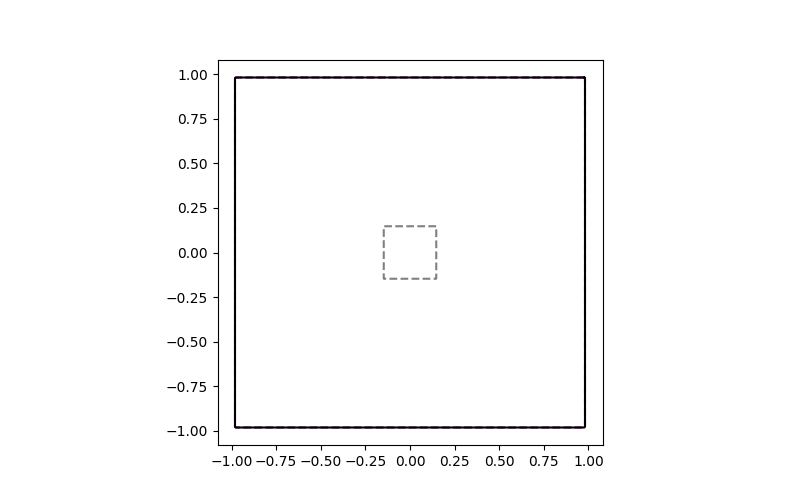

In [41]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)
# domain_sdf = lambda x: sampleDomainSDF(x, interiorDomain, invert = False)
obstacle_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([0.15,0.15]).to(points.device)), invert = False)

# box_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([0.5,0.5]).to(points.device)))

# inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/16,L/2]).to(points.device)), torch.tensor([domain.min[0]+L/16,0]).to(points.device)), invert = False)
# outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/12,L]).to(points.device)), torch.tensor([domain.max[0]-L/12,0]).to(points.device)), invert = False)
# outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([L/8,L]).to(points.device)), torch.tensor([domain.max[0]-L/8,0]).to(points.device)), invert = False)


regions = []

# regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'boundary', kind = 'constant'))
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'fluid'))
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'forcing', dirichletValues={'velocities': forcing}))

# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(8, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = False)
axis[0,0].set_aspect('equal')


In [ ]:
from sphMath.modules.particleShifting import computeShifting, solveShifting
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)

particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

for rigidBody in rigidBodies:
    particleState = updateBodyParticles(scheme, particleState, rigidBody)

particleSystem.systemState.positions += torch.randn_like(particleSystem.systemState.positions) * particleSystem.systemState.supports.view(-1,1) * 0.05

configS = {
    'domain': domain,
    'kernel': config['kernel'],
    'verletScale': 1.4,
    'particle': {'dx': config['particle']['dx'], 'support': particles.supports.max().item()},
    'shifting': {'scheme': 'delta',
                'threshold': 5,
                'computeMach': False,
                'summationDensity': True
                }
}

kindMask = particleSystem.systemState.kinds == 0
for i in tqdm(range(256)):
    dx, *_ = solveShifting(particleSystem, 0.1, configS)
    particleSystem.systemState.positions[kindMask,:] += dx[kindMask,:]
    # print(torch.linalg.norm(dx, dim = -1).max().item())
    
config['timestep'] = {'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
dt = computeTimestep(scheme, 1e-2, particleSystem.systemState, config, None)
print(dt)
config['timestep']['dt'] = dt

kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']


initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2

particleState = particleSystem.systemState

t = 0

[0]


  0%|          | 0/256 [00:00<?, ?it/s]

[SPH] - Adaptive Timestep Update
	CFL: 0.3, maxDt: 0.01, minDt: 1e-06
	Diffusion: 0.010861160159025371, deltaSPH_inviscid
	Fluid: 20, 0.0625, 2.171239
	Viscosity: 0.1325153410434723, Acoustic: 0.00043178111081942916, Acceleration: 0.009999999776482582
tensor(0.0004, device='cuda:0')


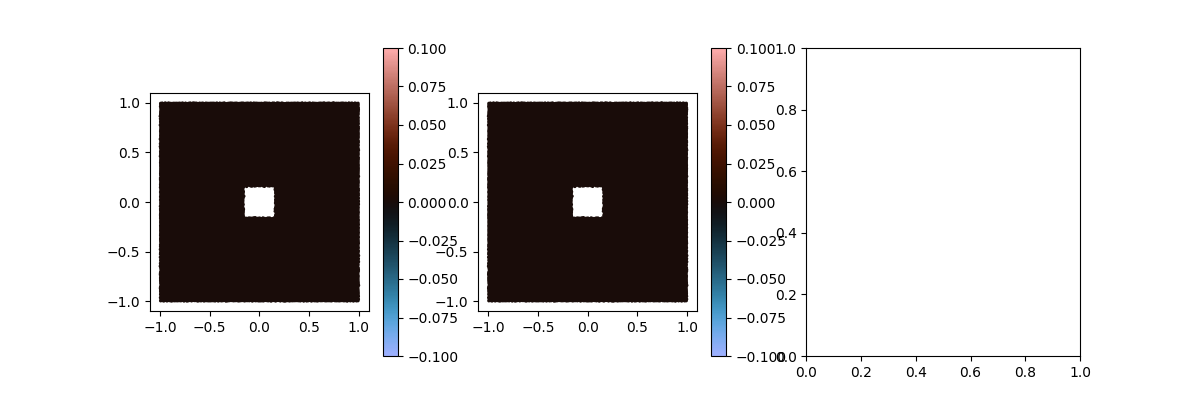

In [43]:

f = forcing(particleState.positions)

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 2
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
# axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize)

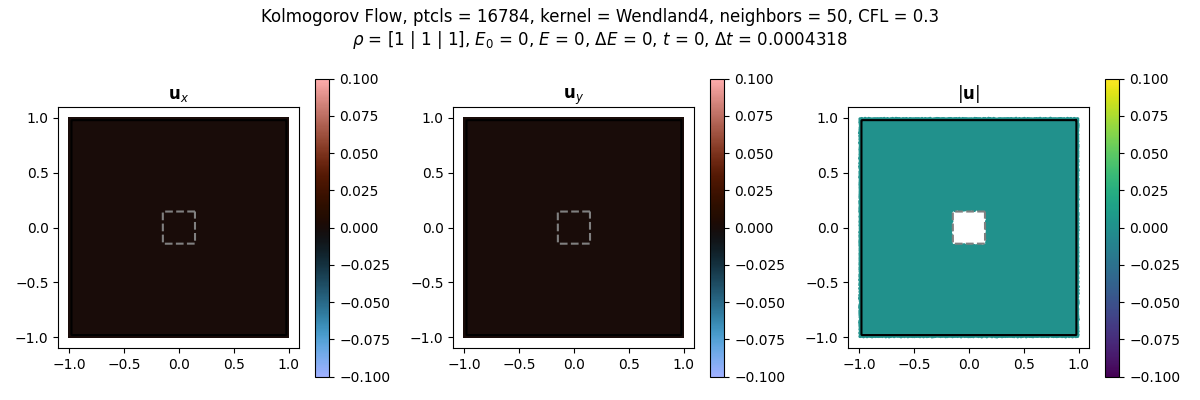

In [46]:
kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 2
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize, streamLines=False)
# axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'berlin',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize)

uidPlot = visualizeParticles(fig, axis[0,2],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = 'L2',
            cmap = 'viridis',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
axis[0,0].set_title(r'$\mathbf{u}_x$')
axis[0,1].set_title(r'$\mathbf{u}_y$')
axis[0,2].set_title(r'$|\mathbf{u}|$')

for ax in axis.flatten():
    plotRegions(regions, ax, plotFluid = False, plotParticles = False)


totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
totalEnergy = (kineticEnergy).sum().detach().cpu().item()

fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

fig.tight_layout()

In [47]:
imagePrefix = './images/Kolmogorov4/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)


In [48]:
config['shifting']['summationDensity'] = False
config['shifting']['computeMach'] = True
config['shifting']['projectQuantities'] = True
config['diffusion'] = {'alpha': 0.1}

In [49]:
particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
plotInterval = 50

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, deltaPlusSPHScheme, config, priorStep = particleSystem.priorStep, verbose = False)
    particleSystem.priorStep = None


    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {particleSystem.t:.4g}, $\Delta t$ = {dt:.4g}')

        updatePlot(vxPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(vyPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.velocities)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/23159 [00:00<?, ?it/s]

In [50]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i '+ imagePrefix + '/frame_*.png -c:v libx264 -b:v 20M -r 50 ' + imagePrefix + '/output.mp4'
commandB = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -vf "fps=50,scale={scale}:-1:flags=lanczos,palettegen" {imagePrefix}/palette.png'
commandC = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -i {imagePrefix}/palette.png -filter_complex "fps=50,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {imagePrefix}/output.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(imagePrefix))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')


Creating video from  frames (frame count: 465)
Creating gif palette
Creating gif
Done
